In [18]:
import pandas as pd
import sklearn.metrics as skm
import numpy as np

import seaborn as sns
sns.set_theme()

In [ ]:
#TAGGED_SAMPLED_TOKENS_CSV_NAME = 'english_samples_v4_annotations.csv'#'sampled_tagged.csv' # 'english_samples_v4_annotations.csv'
#TAGGER_TO_CHILDES_POS_MAPPING_CSV_NAME = "spacy_childes_pos_mapping_full - spacy_childes_pos_mapping_full.csv"
#CHILDES_POS_REMAPPING_CSV_NAME = "childes_pos_remapping_full - childes_simplified_pos_full.csv"
#MODEL_NAME = 'spacy'
#CONVERTED_SAMPLED_TOKENS_CSV_NAME = 'sampled_remapped.csv'

In [119]:
annotations = "french_samples_gold_remapped_short_v1.csv"
df = pd.read_csv(annotations, keep_default_na=False, index_col=0)
df = df.head(777)
df = df.drop(df.columns[0:7], axis=1)
df = df.drop(df.columns[1:3], axis=1)
df = df.drop(df.columns[2:11], axis=1)

df= df.rename(index=str, columns={"Big_category": "correct_pos", "Big_category_clan": "childes_remapped_part_of_speech", "Big_category_spacy": "spacy_pos_converted"})
print(df.columns)


Index(['speaker_role', 'log_frequency_bin', 'correct_pos',
       'childes_remapped_part_of_speech', 'spacy_pos_converted'],
      dtype='object')


In [120]:
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

def print_confusion_matrix(df, col_evaluate, plot_title=None, file_name=None, normalized=False):
    """
    df: dataframe with columns `correct_pos`, col_evaluate
    col_evaluate: name of column to evaluate against `correct_pos`, e.g. `childes_remapped_part_of_speech`, `spacy_pos_converted`
    plot_title: title of plot
    file_name: file name to save plot under
    normalized: use proportions if True, use raw values if False
    
    Adapted from https://seaborn.pydata.org/examples/structured_heatmap.html
    """
    
    gold_labels = list(df['correct_pos'])
    childes_labels = list(df[col_evaluate])
    labels = list(set(gold_labels) | set(childes_labels))
    
    # Create a categorical palette to identify the networks
    # network_pal = sns.husl_palette(8, s=.45)
    network_pal = sns.husl_palette(len(labels), s=.45)
    # network_lut = dict(zip(map(str, used_networks), network_pal))
    network_lut = dict(zip(map(str, labels), network_pal))

    # Convert the palette to vectors that will be drawn on the side of the matrix
    # networks = df.columns.get_level_values("network")
    networks = labels
    network_colors = pd.Series(networks).map(network_lut).to_numpy()

    vals = skm.confusion_matrix(df["correct_pos"], df[col_evaluate], labels=labels)
    #print(vals)
    if normalized:
        vals_norm = np.nan_to_num(vals/vals.astype(np.float).sum(axis=1)[:, np.newaxis], nan=0)
        vals_labeled = pd.DataFrame(vals_norm, columns = labels, index = labels)
    else:
        vals_labeled = pd.DataFrame(vals, columns=labels, index=labels)
    # Draw the full plot
    '''g = sns.clustermap(vals_labeled, center=0, cmap="vlag",
                       row_colors=network_colors, col_colors=network_colors,
                       dendrogram_ratio=(.1, .2),
                       cbar_pos=(.02, .32, .03, .2),
                       linewidths=.75, figsize=(12, 13), annot=True)''' # for linear color scale
    
    #ticks = [0, 0.05, 0.1, 0.2, 0.5, 0.8, 1]
    ticks = [i/10 for i in range(0,11)]
    g = sns.clustermap(vals_labeled, center=0, cmap="vlag",
                       row_colors=network_colors, col_colors=network_colors,
                       dendrogram_ratio=(.1, .2),
                       cbar_pos=(.02, .32, .03, .2),
                       linewidths=.75, figsize=(12, 13), annot=True, 
                       cbar_kws={'ticks': ticks},
                       xticklabels=True, yticklabels=True,
                       norm=PowerNorm(0.5))
    g.ax_heatmap.collections[0].colorbar.set_ticklabels(ticks)
    
    # Remove dendrograms (trees)
    g.ax_row_dendrogram.remove()
    g.ax_col_dendrogram.remove()
    
    # Add plot title
    # Position of title might be bad with other dfs, adjust position by changing value of `y`
    plt.suptitle(plot_title, fontsize = 16, y=0.85)
    
    # Label axes
    ax = g.ax_heatmap
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("Actual label")

    if file_name:
        g.savefig(file_name)
    

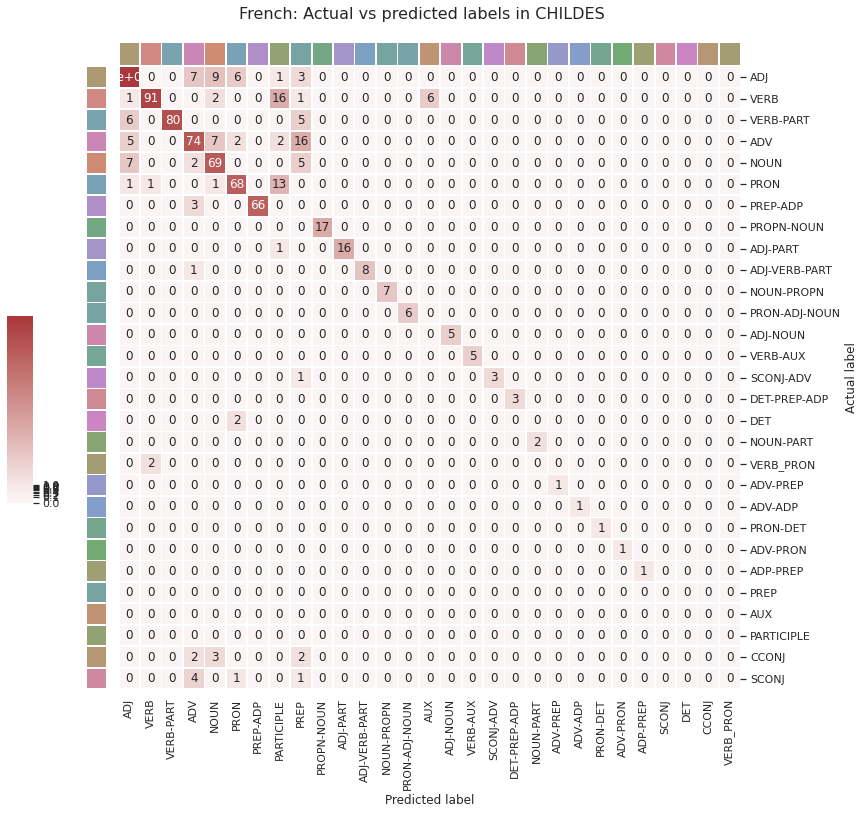

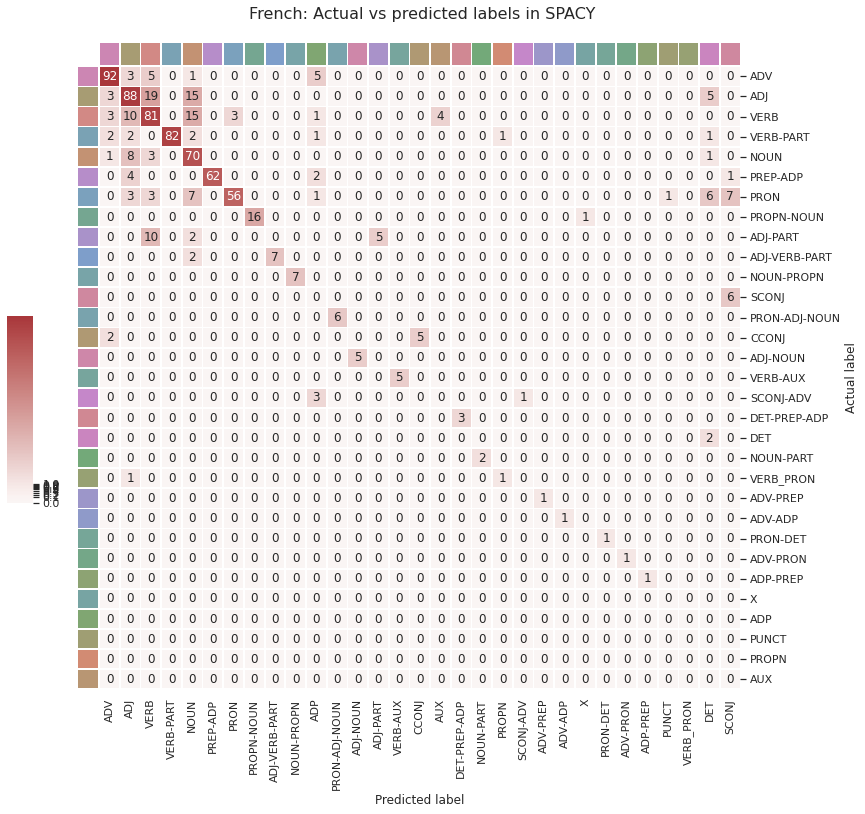

In [107]:
print_confusion_matrix(df, 'childes_remapped_part_of_speech', 
                       plot_title='French: Actual vs predicted labels in CHILDES', 
                       file_name="french_childes_confusion_matrix.jpg")
print_confusion_matrix(df, 'spacy_pos_converted', 
                       plot_title='French: Actual vs predicted labels in SPACY', 
                       file_name="french_spacy_confusion_matrix.jpg")

#print_confusion_matrix(df, '{}_pos_converted'.format(MODEL_NAME), 
 #                      plot_title='Actual vs predicted labels by {}'.format(MODEL_NAME), 
  #                     file_name="english_{}_confusion_matrix.jpg".format(MODEL_NAME))  


In [121]:

new_samples=df
def correct_score(df, use_childes=True):
    if use_childes:
        col_name = "childes_remapped_part_of_speech"
    else:
        col_name = 'spacy_pos_converted'
        
    labels = df[col_name].drop_duplicates()
    p = skm.precision_score(new_samples["correct_pos"], new_samples[col_name], labels=labels, average='micro')
    r = skm.recall_score(new_samples["correct_pos"], new_samples[col_name], labels=labels, average='micro')
    f1 = skm.f1_score(new_samples["correct_pos"], new_samples[col_name], labels=labels, average='micro')
    return {'precision': p, 'recall': r, 'f1': f1}

def print_scores_by_group(by):
    groupby = new_samples.groupby(by=by)
    for name, group in groupby:
        print(name)
        # print(group)
        print(correct_score(group))

print("childes:", correct_score(df))
print("spacy:", correct_score(df, use_childes=False))

print_scores_by_group('correct_pos')


# judge by utterance length
'''
utt_len_samples = df.copy()
utt_len_samples['utterance_length'] = utt_len_samples.apply(lambda x: len(x['utterance_gloss']), axis=1)
gb = utt_len_samples.groupby(by='utterance_length')
for name, group in gb:
    print(name)
    print(correct_score(group))
'''

childes: {'precision': 0.8095238095238095, 'recall': 0.8276315789473684, 'f1': 0.8184775536759922}
spacy: {'precision': 0.7799227799227799, 'recall': 0.7819354838709678, 'f1': 0.7809278350515464}
ADJ
{'precision': 0.6938325991189427, 'recall': 0.7816377171215881, 'f1': 0.7351225204200701}
ADJ-NOUN
{'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
ADJ-PART
{'precision': 0.32653061224489793, 'recall': 0.9411764705882353, 'f1': 0.48484848484848486}
ADJ-VERB-PART
{'precision': 0.8118811881188119, 'recall': 0.7130434782608696, 'f1': 0.7592592592592593}
ADP-PREP
{'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
ADV
{'precision': 0.6938325991189427, 'recall': 0.7816377171215881, 'f1': 0.7351225204200701}
ADV-ADP
{'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
ADV-PREP
{'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
ADV-PRON
{'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
CCONJ
{'precision': 0.6559633027522935, 'recall': 0.7566137566137566, 'f1': 0.7027027027027027}
DET
{'precision': 0.8607594936708861, 'recall'

"\nutt_len_samples = df.copy()\nutt_len_samples['utterance_length'] = utt_len_samples.apply(lambda x: len(x['utterance_gloss']), axis=1)\ngb = utt_len_samples.groupby(by='utterance_length')\nfor name, group in gb:\n    print(name)\n    print(correct_score(group))\n"

In [122]:
print_scores_by_group('speaker_role')



Adult
{'precision': 0.7771739130434783, 'recall': 0.7566137566137566, 'f1': 0.7667560321715818}
Brother
{'precision': 0.8101694915254237, 'recall': 0.8241379310344827, 'f1': 0.8170940170940171}
Caretaker
{'precision': 0.7947269303201506, 'recall': 0.7858472998137802, 'f1': 0.7902621722846441}
Father
{'precision': 0.8394366197183099, 'recall': 0.8220689655172414, 'f1': 0.8306620209059234}
Friend
{'precision': 0.7186813186813187, 'recall': 0.7975609756097561, 'f1': 0.7560693641618498}
Grandfather
{'precision': 0.8543689320388349, 'recall': 0.8, 'f1': 0.8262910798122066}
Grandmother
{'precision': 0.8077571669477235, 'recall': 0.8036912751677853, 'f1': 0.8057190916736754}
Investigator
{'precision': 0.8114209827357237, 'recall': 0.8245614035087719, 'f1': 0.8179384203480589}
Media
{'precision': 0.9190751445086706, 'recall': 0.7910447761194029, 'f1': 0.8502673796791445}
Mother
{'precision': 0.8090322580645162, 'recall': 0.8271767810026385, 'f1': 0.8180039138943249}
Relative
{'precision': 0.83

In [123]:
print_scores_by_group('log_frequency_bin')

0
{'precision': 0.8099062918340026, 'recall': 0.8231292517006803, 'f1': 0.816464237516869}
1
{'precision': 0.8099062918340026, 'recall': 0.8231292517006803, 'f1': 0.816464237516869}
2
{'precision': 0.8131578947368421, 'recall': 0.8262032085561497, 'f1': 0.8196286472148541}
3
{'precision': 0.8065359477124183, 'recall': 0.8248663101604278, 'f1': 0.8155981493721083}
4
{'precision': 0.7991858887381276, 'recall': 0.8203342618384402, 'f1': 0.8096219931271478}


In [ ]:
new_samples.to_csv()